In [77]:
from math import sin, sqrt, log, exp

import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
from matplotlib import cm

from preg import Preg, Logger

plt.rcParams['figure.figsize'] = [20/2.54, 16/2.54]

In [78]:
# zero forcing for simulating autonomous system
def zero_forcing(t):
    return 0.0

# Linear system with a stable spiral fixed point attractor.
def lin_sys(y,t, inp):
    u = inp(t)
    return np.dot(np.array([[-1, -2], [3, -1]]), np.array([y[0],y[1]])+\
        np.array([u,0]))

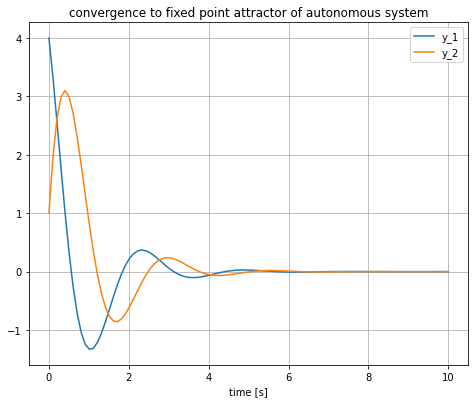

In [79]:
# 1. Simulation: converge to the fixed point attractor of the autonomous
# system
n = 100                     # number of time steps
t0, t1 = 0, 10              # start and end
t = np.linspace(t0, t1, n)  # the points of evaluation of solution
h = t[1]-t[0]               # time step
y0 = [4, 1]                 # initial value
y = integrate.odeint(lin_sys, y0, t, (zero_forcing,))

plt.plot(t, y)
plt.title('convergence to fixed point attractor of autonomous system')
plt.xlabel('time [s]')
plt.grid(True)
plt.legend(('y_1', 'y_2'),loc='upper right')
plt.show()

# The attractor (we know it's simply the origin (0,0))
y_a = y[-1,:]

In [80]:
def step_forcing(t):
    if t >= 0:
        return 1.0
    return 0.0

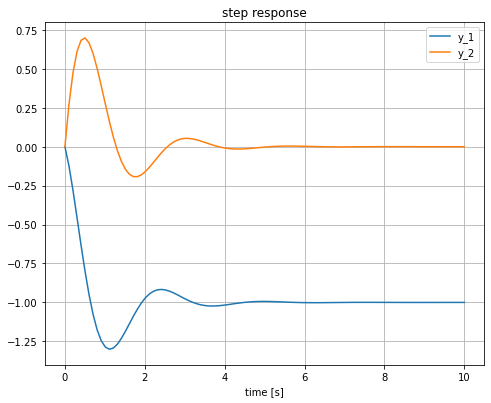

In [81]:
# 2. Force the system by a step-wise input u(t) being initially situated on
# the attractor
y_step = integrate.odeint(lin_sys, y_a, t, (step_forcing,))

plt.plot(t, y_step)
plt.title('step response')
plt.xlabel('time [s]')
plt.grid(True)
plt.legend(('y_1', 'y_2'),loc='upper right')
plt.show()

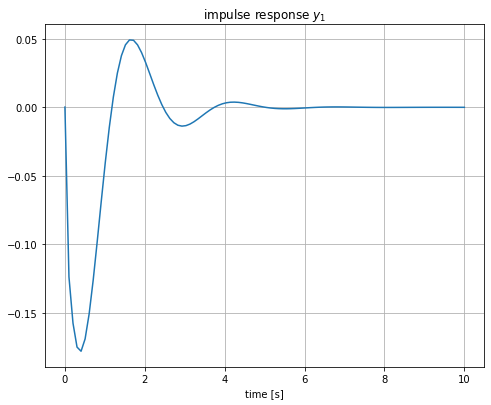

In [82]:
# The linear or first-order (1) impulse response function (IRF), a.k.a.
# Volterra kernel: http://www.scholarpedia.org/article/Volterra_and_Wiener_series
h_1 = np.diff(y_step[:,0], prepend=0)

plt.plot(t, h_1)
plt.title('impulse response $y_1$')
plt.xlabel('time [s]')
plt.grid(True)
plt.show()

In [83]:
def sine_forcing(t):
    om = 1
    return sin(om*t)

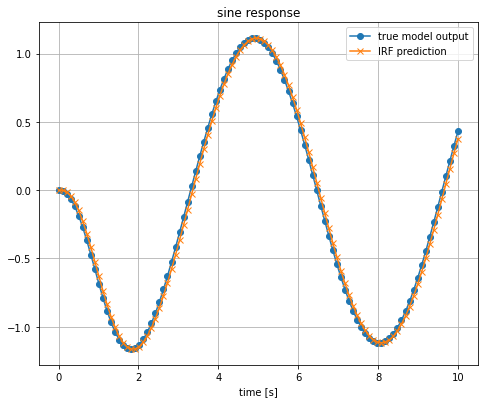

In [84]:
# 3. Test the prediction performed by using the IRF; apply any desirable
# forcing
y_sine = integrate.odeint(lin_sys, y_a, t, (sine_forcing,))
u_sine = np.array([sine_forcing(t2) for t2 in t])
y_pr1 = np.convolve(u_sine, h_1, 'full')
y_pr1 = y_pr1[:n]

plt.plot(t, y_sine[:,0], '-o', t, y_pr1, '-x')
plt.title('sine response')
plt.xlabel('time [s]')
plt.grid(True)
plt.legend(('true model output', 'IRF prediction'),loc='upper right')
plt.show()

In [85]:
# convert step input to sliding window format for regression (see 4.)
memory = n # how may sampling points back in time are used as input for the Volterra operators
u1 = np.zeros(n + memory - 1)
u1[memory:] = np.ones(n-1) # create step input by prepending zeros
x0 = np.zeros((n, memory))
for i in range(0,n):
    x0[i,:] = u1[i:i + memory]
y0 = y_step[:,0] # associated output

# convert sine input to sliding window format for regression (see 4.)
u2 = np.zeros(n + memory - 1)
u2[memory-1:] = u_sine
x1 = np.zeros((n, memory))
for i in range(0,n):
    x1[i,:] = u2[i:i + memory]

Preg Ver. 1.4.4, IOS Konstanz
Linesearch      1;  Value -1.357421e+00
Linesearch      2;  Value -1.436752e+00
Linesearch      3;  Value -1.458644e+00
Linesearch      4;  Value -1.466770e+00
Linesearch      5;  Value -1.469108e+00
Linesearch      6;  Value -1.470932e+00
Linesearch      7;  Value -1.470937e+00
Linesearch      8;  Value -1.470940e+00
Linesearch      9;  Value -1.470995e+00
Linesearch     10;  Value -1.471008e+00
Linesearch     11;  Value -1.471018e+00
Linesearch     12;  Value -1.471018e+00
Linesearch     13;  Value -1.471019e+00
Linesearch     14;  Value -1.471019e+00
Linesearch     15;  Value -1.471019e+00
Linesearch     16;  Value -1.471019e+00
Linesearch     17;  Value -1.471019e+00
Linesearch     18;  Value -1.471019e+00
Linesearch     19;  Value -1.471019e+00
Linesearch     20;  Value -1.471019e+00
Best value: -1.471019e+00
Used 20 iterations, minval -1.471


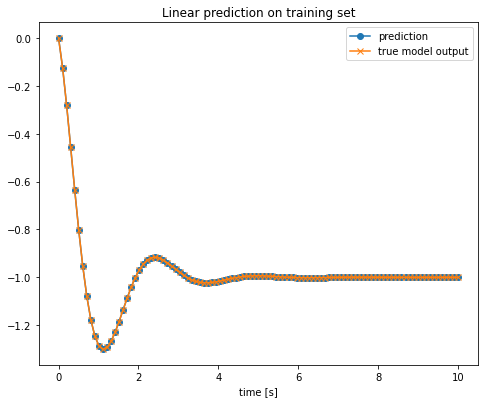

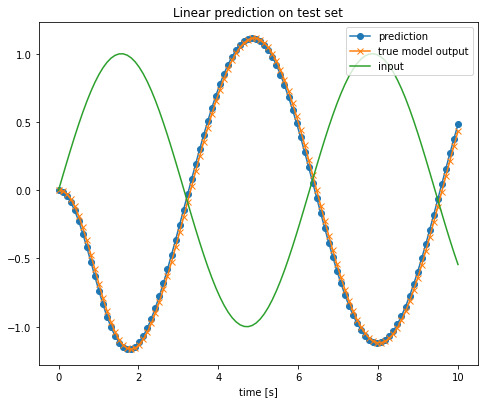

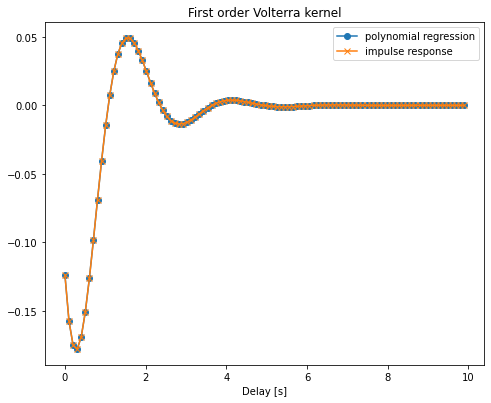

In [86]:
# 4. Obtain h_1 using poly_reg
with Logger('linear') as lg: # get a logger instance

    ptype = 'ihp'		# kernel type ('ihp' or 'ap')
    method = 'gpp'		# model selection method ('llh', 'gpp', 'loo')
    n_iter = 20		    # number of iterations
    order = 1           # Volterra series order

    # regression
    hp0 = [log(0.6), log(sqrt(0.001))]
    gp = Preg(lg, ptype, order, hp0) # init GP struct
    gp.ams(x0, y0, method, n_iter)     # do regression
    mu_step = gp.predict(x0)    # predict on training input

    # plot prediction on training set
    plt.plot(t, mu_step, '-o', t, y0, '-x')
    plt.title('Linear prediction on training set')
    plt.xlabel('time [s]')
    plt.legend(('prediction','true model output'),loc='upper right')
    plt.show()

    # prediction on test set (sine)
    mu_sine = gp.predict(x1)
    plt.plot(t, mu_sine, '-o', t, y_sine[:,0], '-x', t, u_sine)
    plt.title('Linear prediction on test set')
    plt.xlabel('time [s]')
    plt.legend(('prediction','true model output','input'),loc='upper right')
    plt.show()

    # compute explicit 1st-order Volterra operator
    eta = gp.volt(order)
    eta = np.flip(eta)
    plt.plot(t[:n-1], eta[:n-1], '-o', t[:n-1], np.diff(y_step[:,0]), '-x')
    plt.title('First order Volterra kernel')
    plt.xlabel('Delay [s]')
    plt.legend(('polynomial regression','impulse response'),loc='upper right')
    plt.show()

In [87]:
# simulate 2nd-order nonlinear system with smooth input
xtr = np.concatenate((y_step[:,1], np.flip(y_step[:,1]), y_step[:,1],))
ntr = len(xtr)
y_nl = np.convolve(xtr, h_1, 'full')
y_nl = y_nl[:ntr+1]
y_nl = y_nl**2
ttr = np.arange(0,h*(ntr - memory + 1),h)
x2 = np.zeros((len(ttr), memory))
y2 = np.zeros((len(ttr),))
for i in range(0,len(y2)):
    x2[i,:] = xtr[i:i + memory]
    y2[i] = y_nl[i + memory - 1]

Preg Ver. 1.4.4, IOS Konstanz
Linesearch      1;  Value -8.032112e+00
Best value: -8.032112e+00
Used 3 iterations, minval -8.032


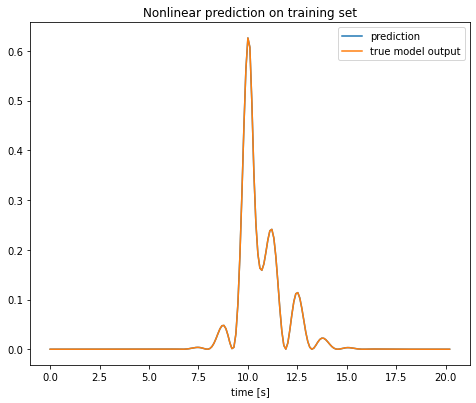

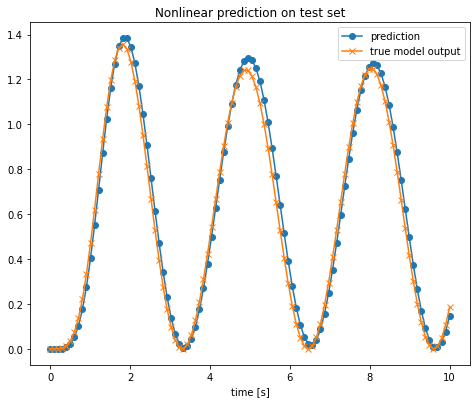

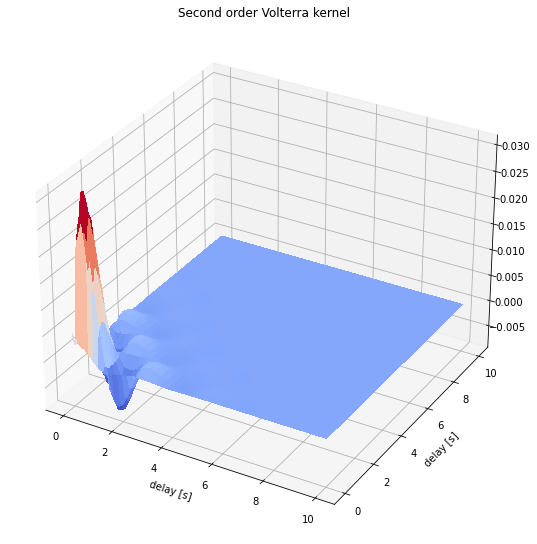

In [88]:
# 5. Obtain second-order Volterra kernel for a nonlinear operator
# do regression and predict on training data
with Logger('nonlinear') as lg: # get a logger instance

    order = 2           # Volterra series order

    # regression
    hp0 = [log(0.6), log(sqrt(0.001))]
    gp_nl = Preg(lg, ptype, order, hp0) # init GP struct
    gp_nl.ams(x2, y2, method, n_iter)     # do regression
    mu_nl = gp_nl.predict(x2)    # predict on training input

    # plot prediction on training set
    plt.plot(ttr, mu_nl, ttr, y2) #, ttr, xtr[memory-1:memory+len(ttr)-1])
    plt.title('Nonlinear prediction on training set')
    plt.xlabel('time [s]')
    plt.legend(('prediction','true model output','input'),loc='upper right')
    plt.show()

    # prediction on test set (sine)
    mu_sine_nl = gp_nl.predict(x1)
    plt.plot(t, mu_sine_nl, '-o', t, y_sine[:,0]**2, '-x')
    plt.title('Nonlinear prediction on test set')
    plt.xlabel('time [s]')
    plt.legend(('prediction','true model output'),loc='upper right')
    plt.show()

    # 2nd-order Volterra kernel
    eta = gp_nl.volt(order)
    eta = np.flipud(np.fliplr(eta)) # time delay is measured in reverse time direction
                                    # kernel mst be flipped for standrad display
                                    # convention
    xv, yv = np.meshgrid(t, t)
    plt.rcParams['figure.figsize'] = [30/2.54, 24/2.54]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xv, yv, eta, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    ax.set_xlabel('delay [s]')
    ax.set_ylabel('delay [s]')
    plt.title('Second order Volterra kernel')
    plt.show()